# Introduction
There are several methods for implementing Markov Chain Monte Carlo, including Metropolis–Hastings algorithm, Slice sampling, Hamiltonian (or Hybrid) Monte Carlo etc. I tried to use Metropolis–Hastings and Hamiltonian MC in this project. The steps of data manipulation before the MCMC algorithms in this project are highly equivalent to the example made by WillKoehrsen.

Github (Source Code): https://github.com/WillKoehrsen/ai-projects/blob/master/markov_chain_monte_carlo/markov_chain_monte_carlo.ipynb

Medium (Full Article): https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib

import json
s = json.load(open('../style/bmh_matplotlibrc.json'))
#matplotlib.rcParams.update(s)
matplotlib.rcParams['figure.figsize'] = (10, 3)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['ytick.major.size'] = 20

# Number of samples for Markov Chain Monte Carlo
N_SAMPLES = 5000

In [2]:
# Data formatted in different notebook
sleep_data = pd.read_csv('data/sleep_data.csv')
wake_data = pd.read_csv('data/wake_data.csv')

# Labels for plotting
sleep_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
wake_labels = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']

In [3]:
print('Number of sleep observations %d' % len(sleep_data))

Number of sleep observations 11340


In [4]:
sleep_data

,Unnamed: 0,indicator,time_offset
0,2017-12-01 21:00:00,0,-60
1,2017-12-01 21:01:00,0,-59
2,2017-12-01 21:02:00,0,-58
3,2017-12-01 21:03:00,0,-57
4,2017-12-01 21:04:00,0,-56
...,...,...,...
11335,2018-02-01 23:55:00,1,115
11336,2018-02-01 23:56:00,1,116
11337,2018-02-01 23:57:00,1,117
11338,2018-02-01 23:58:00,1,118


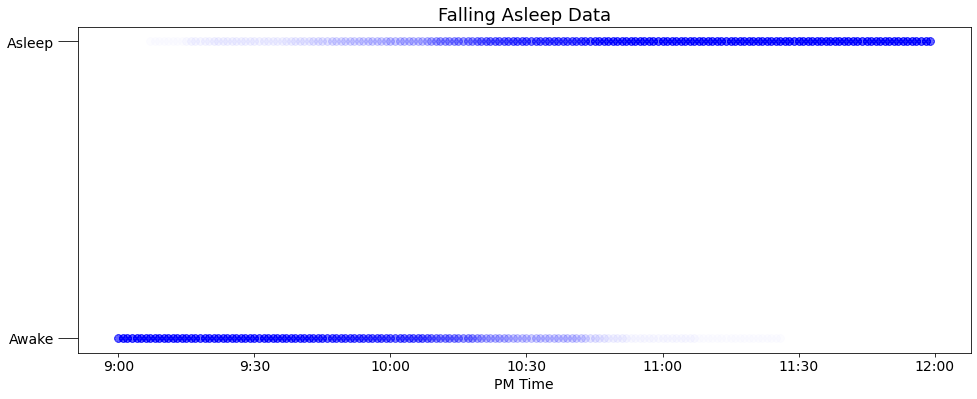

In [5]:
figsize(16, 6)

# Sleep data
plt.scatter(sleep_data['time_offset'], sleep_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b') #alpha: between 0 (transparent) and 1 (opaque)
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('PM Time'); 
plt.title('Falling Asleep Data', size = 18)
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

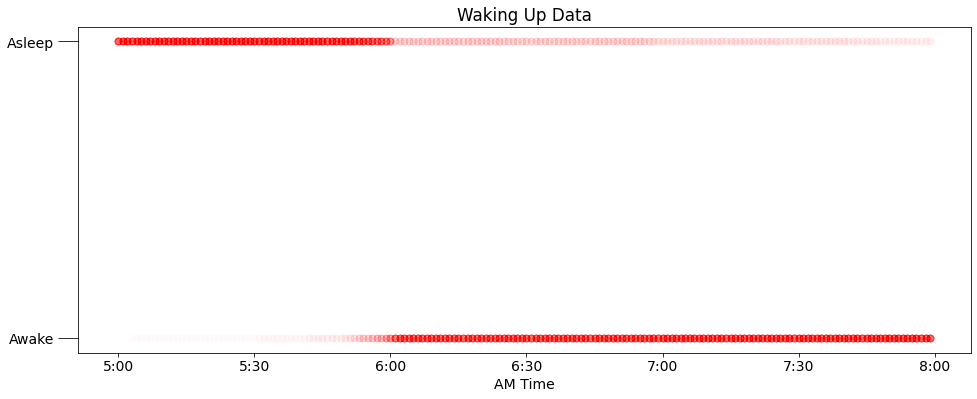

In [6]:
# Wake data
plt.scatter(wake_data['time_offset'], wake_data['indicator'], 
            s= 50, alpha = 0.01, facecolor='r', edgecolors =  'r');
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('AM Time');
plt.title('Waking Up Data')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

The expression for a logistic probability distribution for sleep as a function of time is:
$$p(s|t) = \frac{1}{ 1 + e^{\;\beta t } }$$

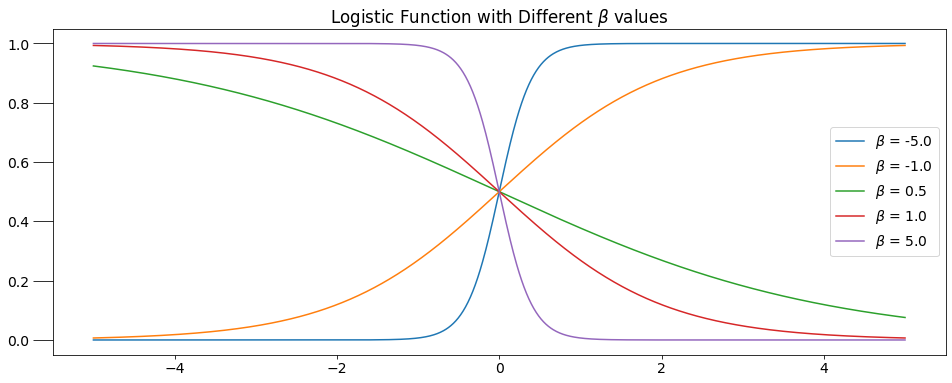

In [7]:
figsize(16, 6)

# Logistic function with only beta
def logistic(x, beta):
    return 1. / (1. + np.exp(beta * x))

# Plot examples with different betas 
x = np.linspace(-5, 5, 1000)
for beta in [-5, -1, 0.5, 1, 5]:
    plt.plot(x, logistic(x, beta), label = r"$\beta$ = %.1f" % beta)

plt.legend();
plt.title(r'Logistic Function with Different $\beta$ values');

 The logistic function now is:

$$p(t) = \frac{1}{ 1 + e^{\;\beta t + \alpha} }$$


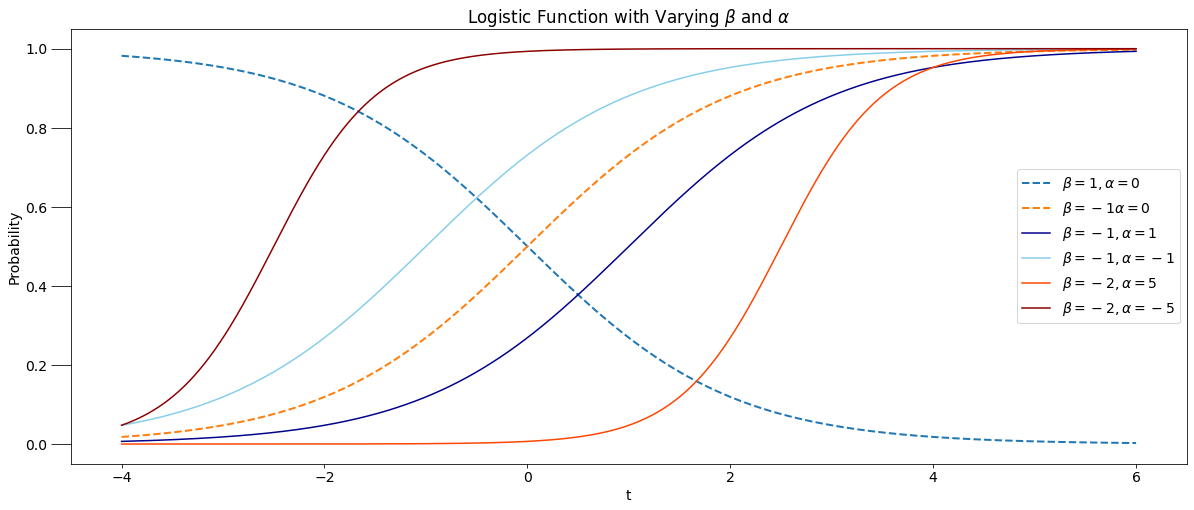

In [8]:
figsize(20, 8)

# Logistic function with both beta and alpha
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 6, 1000)

plt.plot(x, logistic(x, beta=1), label=r"$\beta = 1, \alpha = 0$", ls="--", lw=2)
plt.plot(x, logistic(x, beta=-1), label=r"$\beta = -1 \alpha = 0$", ls="--", lw=2)

plt.plot(x, logistic(x, -1, 1), 
         label=r"$\beta = -1, \alpha = 1$", color="darkblue")
plt.plot(x, logistic(x, -1, -1),
         label=r"$\beta = -1, \alpha = -1$",color="skyblue")
plt.plot(x, logistic(x, -2, 5), 
         label=r"$\beta = -2, \alpha = 5$", color="orangered")
plt.plot(x, logistic(x, -2, -5), 
         label=r"$\beta = -2, \alpha = -5$", color="darkred")
plt.legend(); plt.ylabel('Probability'); plt.xlabel('t')
plt.title(r'Logistic Function with Varying $\beta$ and $\alpha$');

## Prior Distribution for $\beta$ and $\alpha$

The normal, or Gaussian, distribution is defined by the mean, $\mu$, and the precision, $\tau$. The precision is the reciprocal of the variance, $\sigma^2$. A larger value of $\tau$ indicates the data is less spread out (it is more precise) and hence the variation is smaller. The mean can be either positive or negative, but the precision will always be positive. A normal distribution as defined here is represented as:

$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x - \mu)^2 \right) $$

Probability density functions for three normal distributions are shown below.

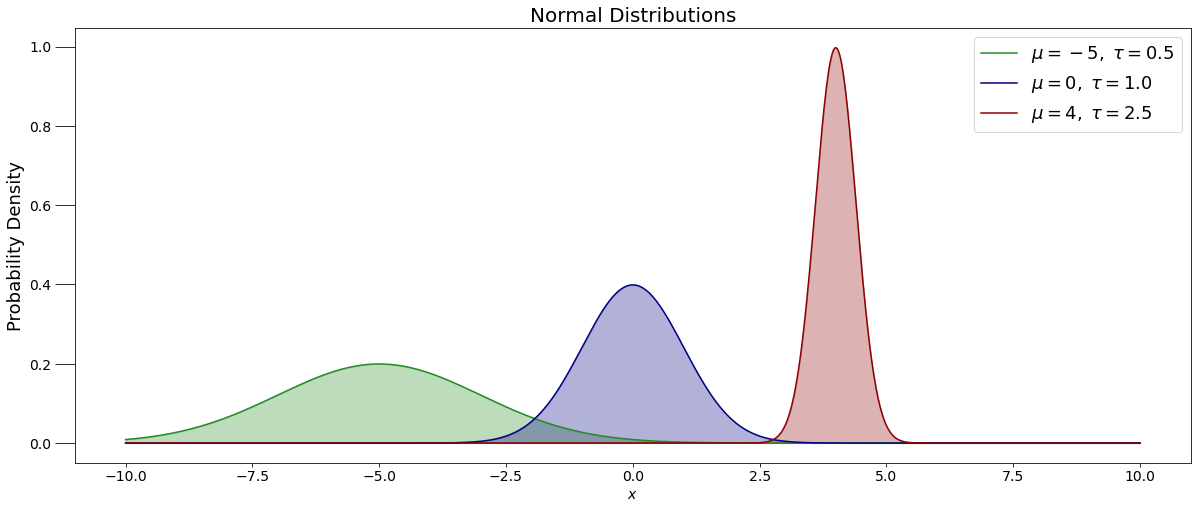

In [9]:
figsize(20, 8)
# Set up the plotting parameters
nor = stats.norm 
x= np.linspace(-10, 10, 1000)
mu = (-5, 0, 4)
tau = (0.5, 1, 2.5)
colors = ("forestgreen", "navy", "darkred")

# Plot 3 pdfs for different normal distributions
params = zip(mu, tau, colors)
for param in params:
    y = nor.pdf(x, loc = param[0], scale = 1 / param[1])
    plt.plot(x, y, 
             label="$\mu = %d,\;\\tau = %.1f$" % (param[0], param[1]), 
             color = param[2])
    plt.fill_between(x, y, color = param[2], alpha = 0.3)
    
plt.legend(prop={'size':18});
plt.xlabel("$x$")
plt.ylabel("Probability Density", size = 18)
plt.title("Normal Distributions", size = 20);

## Parameter Search Space 

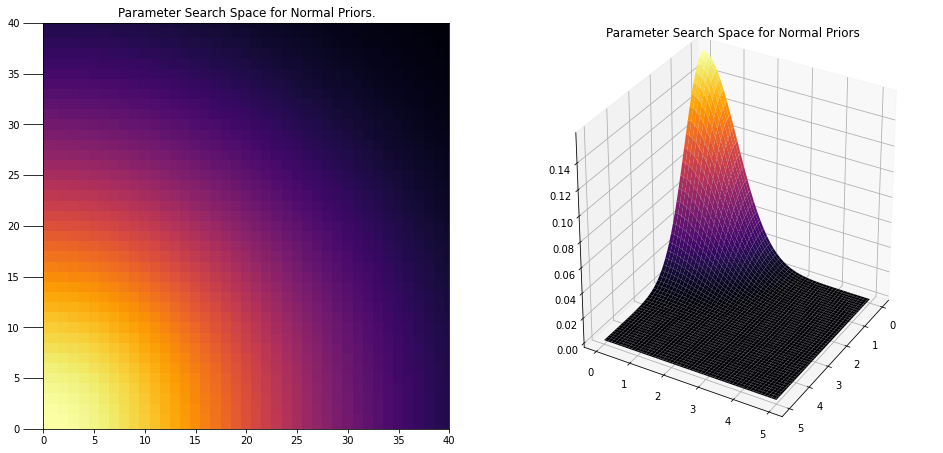

In [10]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(16, 8)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

inferno = plt.cm.inferno #choose color map
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
norm_x = stats.norm.pdf(x, loc=0, scale=1) #cut normal distribution in the scale [0, 100]
norm_y = stats.norm.pdf(y, loc=0, scale=1)
M = np.dot(norm_x[:, None], norm_y[None, :])
plt.imshow(M, interpolation='none', origin='lower',cmap=inferno)

plt.xlim(0, 40)
plt.ylim(0, 40)
plt.title("Parameter Search Space for Normal Priors.")

ax = fig.add_subplot(122, projection='3d') #122 = 1 * 2 plot, subplot number 2 
ax.plot_surface(X, Y, M, cmap=inferno)
ax.view_init(azim=30, elev=30) #azim: rotate along z-axis; elev: rotate along y-axis
plt.title("Parameter Search Space for Normal Priors");

In [11]:
# Sort the values by time offset
sleep_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(sleep_data.loc[:, 'time_offset'])

# Observations are the indicator
sleep_obs = np.array(sleep_data.loc[:, 'indicator'])

In [12]:
N=1000
mean = [0, 0]
cov = [[1, 0.4],[0.4, 1]]
data=np.random.multivariate_normal(mean, cov, N)
x=data[:,0]
y=data[:,1]
data

array([[-0.75939988, -0.58311625],
       [ 0.14420147, -0.01329081],
       [ 0.21962635, -0.79485208],
       ...,
       [-1.98450929, -0.57340642],
       [ 0.71374881,  2.47620439],
       [-1.77752047,  0.7253246 ]])

In [13]:
with pm.Model() as sleep_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed data
    observed = pm.Bernoulli('obs', p, observed=sleep_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    sleep_trace = pm.sample(N_SAMPLES, step=step, cores=2);

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:18<00:00, 592.58draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [14]:
observed

obs

### Reducing Correlation

MCMC methods were created to address multi-dimentional problems better than generic Monte Carlo algorithms.Whereas, the <b>curse of dimensionality</b> (the phenomena that when the dimensionality increases, the volume of the space increases so fast  that the available data become sparse) appears commonly. One way to lessen the problem is to decrease the steps of the walker, so that the process would be <b>highly autocorrelated</b> and expensive (i.e. many steps would be required for an accurate result). More sophisticated methods such as <b>Hamiltonian Monte Carlo</b> and the Wang and Landau algorithm use various ways of reducing this autocorrelation, while managing to keep the process in the regions that give a higher contribution to the integral. 

Wiki: https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo

# Metropolis-Hastings

### About The Algorithm
There are two key components in Metropolis-Hastings algorithm, proposal distribution and acceptance function. In general, the proposal distribution is used to determine the way we want to update the parameter which we need to estimate, and the acceptance function is the tool that generates the probability of acceptance (whether the estimated value is able to replace the current value). In the first step of Metropolis-Hastings algorithm, we need to initialize a value from a specific distribution $q$:

$$ Initialize\;\; x^{(0)}\sim q(x) $$

It's the value of state zero. After that, we need to draw a proposal sample based on the value of the past state (state zero). The value will be a candidate value of the current state. For instance, if the proposal sample is choosen from a normal distribution:

$$ Propose:\; x^{cand}=x^{(i-1)}+Normal(0,\sigma)$$

The form of the algorithms are called Random-walk Metropolis algorithm. Thirdly, we need to justify the value of proposal is appropriate to be the value of the current state (or replace the value of the past state). So, the acceptance fuction appears:

$$\alpha(x^{cand}|x^{(i-1)})=min\{1, {q(x^{(i-1)}|x^{cand})\pi(x^{cand}) \over q(x^{cand}|x^{(i-1)})\pi(x^{(i-1)})}\}$$

Where $\pi(\cdot)\;$is the full joint density. If the proposal distribution is symmetric (Uniform, Gaussian,...), the acceptace fuction will be equivalent to the function below.

$$\alpha(x^{cand}|x^{(i-1)})=min\{1, {\pi(x^{cand}) \over \pi(x^{(i-1)})}\}$$

After calculating the value of acceptance function, $\alpha$,  we can determine whether the proposal value is accepted or rejected to be the value of the current state.

$$ u\sim Uniform(u; 0,1)$$

$u$ can also be drawn from other distributions. If $\alpha > u$, the algorithm will accept the proposal, that is to say, the proposal value will be the value of the current state. Otherwise, the value of the current state will equal to the value of the past state. It is the first loop of the algorithm. After executing N loops, the algorithm will generate N states which based on the proposal distribution and acceptance function (Yildirim, 2012).

### About The Project
In this project, our aim is to estimate two parameters, $\alpha$ and $\beta$, in logistic function.

### Multivariate Normal

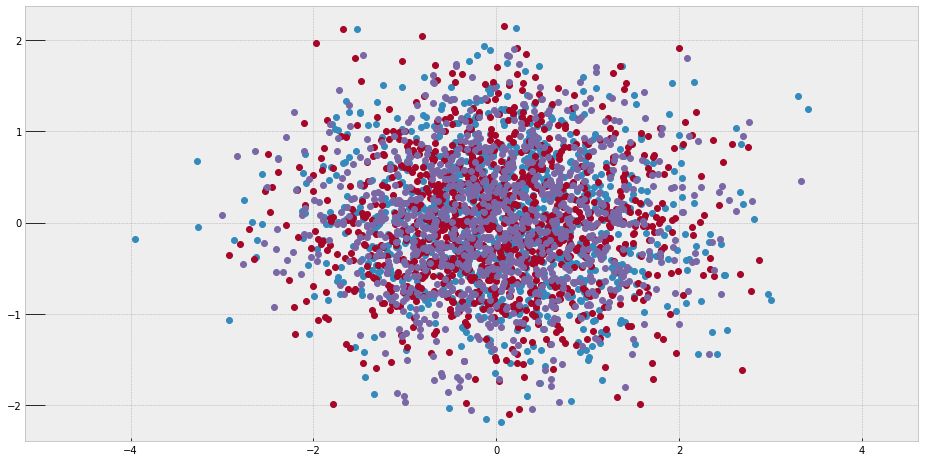

In [149]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('bmh')

mean = [0, 0]
cov = [[1, 0], [0, 0.5]]
x, y = np.random.multivariate_normal(mean, cov, [3, 1000]).T
plt.plot(x,y, 'o')
plt.axis('equal')
plt.show()

### Scatter Plot

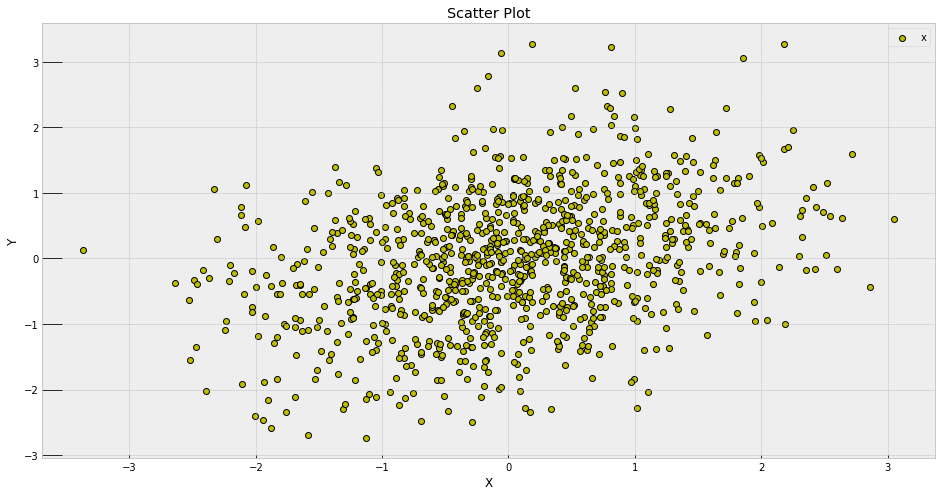

In [163]:
fig = plt.figure()  
ax1 = fig.add_subplot(111) 
ax1.set_title('Scatter Plot')  
plt.xlabel('X')  
plt.ylabel('Y')  
ax1.scatter(x,y,marker = 'o', linewidths=1, edgecolors='k', c = 'y')  
plt.legend('x1')
plt.show()

### Random Walk

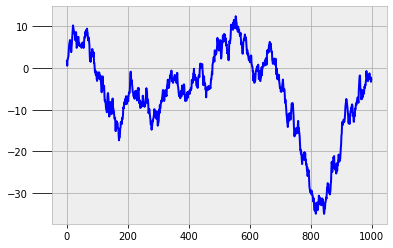

In [6]:
N = 1000
init = 0
record = []
index = []

for i in range(N):    
    x = np.random.normal(0, 1)
    init += x
    record.append(init)
    index.append(i)

plt.plot(index, record, color='b')

# Hamiltonian Monte Carlo

# References
### Metropolis-Hastings:
Yildirim, I. (2012). Bayesian inference: Metropolis-hastings sampling. Dept. of Brain and Cognitive Sciences, Univ. of Rochester, Rochester, NY.